In [886]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

In [887]:
# Load the dataset
df_ben_ddos = pd.read_csv('df_ben_ddos.csv')
df_ben_ddos

,id.orig_addr,id.orig_port,id.resp_haddr,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes,Category
0,3232235972,48438,2300985238,23,1,5.030600,4,1,60,0,0,0
1,3232235972,33878,1352962162,23,1,3.089012,4,3,180,0,0,0
2,3232235972,55416,1539874379,23,1,3.089276,4,3,180,0,0,0
3,3232235972,47778,2258007740,23,1,5.030600,4,1,60,0,0,0
4,3232235972,46752,1732534418,23,1,3.130498,4,3,180,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2314090,3232235971,59699,2734184663,62336,1,5.030600,0,0,0,0,0,1
2314091,3232235971,32909,2734184663,62336,1,5.030600,0,0,0,0,0,1
2314092,3232235971,25120,2734184663,62336,1,5.030600,0,0,0,0,0,1
2314093,3232235971,30340,2734184663,62336,1,5.030600,0,0,0,0,0,1


In [888]:
# Sampled dataset, it could be either random rows or 10k from beningn and 10k from malicious to balance the trained dataset
import ipaddress

#df_sampled = df_ben_ddos.sample(frac=0.01, random_state=42)
df_first = df_ben_ddos[:70000].sample(n=10000, random_state=42)
df_last = df_ben_ddos[80000:].sample(n=10000, random_state=42)
# df_first = df_ben_ddos[1000:1500]
# df_last = df_ben_ddos[81000:82000]
df_gan = pd.read_csv('gan_flows/denormalized_flows.csv')
# df_gan['id.orig_addr'] = df_gan['id.orig_addr'].map(lambda ip: int(ipaddress.IPv4Address(ip)))
# df_gan['id.resp_haddr'] = df_gan['id.resp_haddr'].map(lambda ip: int(ipaddress.IPv4Address(ip)))
df_sampled = pd.concat([df_first, df_last, df_gan])
# df_sampled = pd.concat([df_first, df_last])
#
# min_values = []
# max_values = []
# for col in df_sampled:
#     min_values.append(min(df_sampled[col]))
#     max_values.append(max(df_sampled[col]))
#
# print(min_values)
# print(max_values)

In [889]:
# Separate features and target labels
X = df_sampled.drop(columns=['Category', 'id.orig_addr', 'id.resp_haddr'])
# X = df_sampled.drop(columns=['Category', 'id.resp_haddr', 'id.resp_pport', 'proto_enum', 'conn_state_string', 'resp_pkts_count', 'resp_bytes'])
y = df_sampled['Category']
X

,id.orig_port,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes
46730,5151,53,2,5.030600,4,1,540,0,0
48393,61215,53,2,5.030600,4,1,540,0,0
41416,60587,53,2,5.030600,4,1,540,0,0
34506,52092,23,1,3.119981,4,3,180,0,0
43725,5566,53,2,5.030600,4,1,540,0,0
...,...,...,...,...,...,...,...,...,...
6370,53443,42564,1,59.000000,6,71,1093,3,914
6371,37658,51045,1,64.000000,5,70,2775,4,1586
6372,42609,50062,1,66.000000,6,51,2590,3,1368
6373,63301,35273,1,93.000000,5,60,1888,3,1527


In [890]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [891]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [892]:
# Define the neural network with stronger regularization and dropout
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),  # Stronger L2 regularization
    Dropout(0.5),  # Increased dropout
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification output
])

/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [893]:
# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [894]:
# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [895]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,  # Increase the number of epochs since early stopping is applied
    batch_size=64,
    callbacks=[early_stopping],  # Stop training when validation loss stops improving
    verbose=1
)


Epoch 1/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8548 - loss: 0.8123 - val_accuracy: 0.9773 - val_loss: 0.2498
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9736 - loss: 0.2528 - val_accuracy: 0.9951 - val_loss: 0.1489
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9820 - loss: 0.1794 - val_accuracy: 0.9953 - val_loss: 0.1227
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9862 - loss: 0.1489 - val_accuracy: 0.9953 - val_loss: 0.1113
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9891 - loss: 0.1325 - val_accuracy: 0.9953 - val_loss: 0.1013
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9905 - loss: 0.1227 - val_accuracy: 0.9958 - val_loss: 0.0936
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9906 - loss: 0.1142 - val_accuracy: 0.9955 - val_loss: 0.0943
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9922 - loss: 0.1079 - val_accu

In [896]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.9949 - loss: 0.0473
Test Loss: 0.040053725242614746
Test Accuracy: 0.9963980913162231


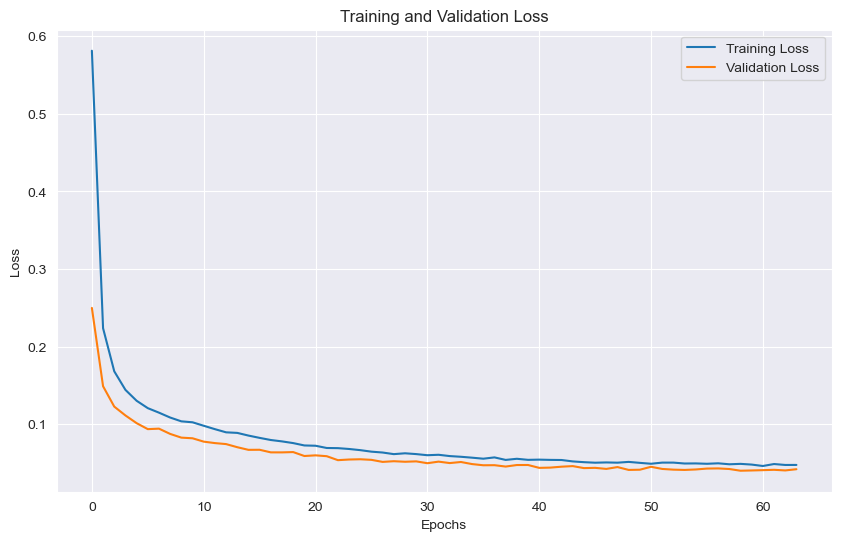

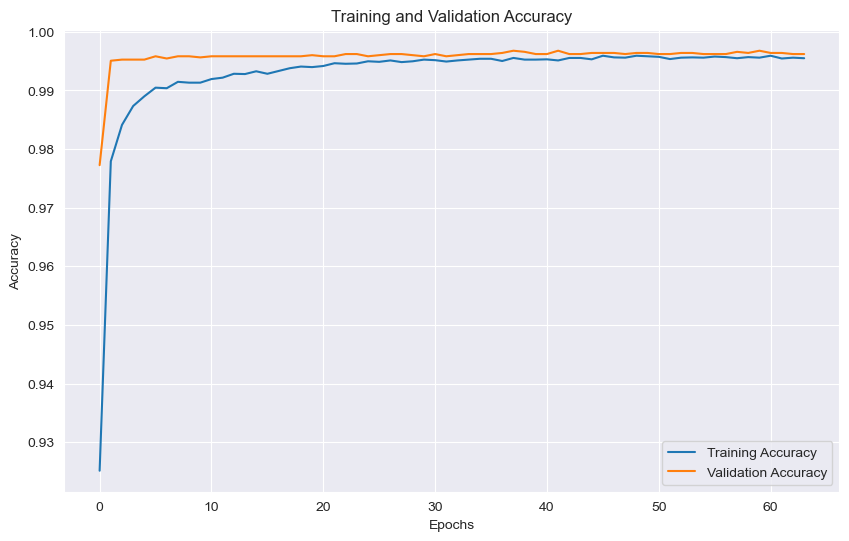

In [897]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [898]:
# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Threshold of 0.5 for binary classification

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


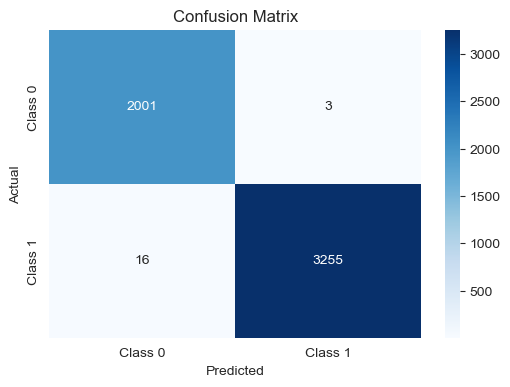

In [899]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [900]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, model.predict(X_test))
print(f"ROC-AUC Score: {roc_auc:.2f}")
model.save('nn.h5')

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.99      1.00      1.00      2004
     Class 1       1.00      1.00      1.00      3271

    accuracy                           1.00      5275
   macro avg       1.00      1.00      1.00      5275
weighted avg       1.00      1.00      1.00      5275

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


ROC-AUC Score: 1.00


In [901]:
import ipaddress
import tensorflow as tf
from keras import layers as l, models as m
import numpy as np
import os

NOISE_DIM = 100
COLUMNS = 9

# id.orig_addr	id.orig_port	id.resp_haddr	id.resp_pport	proto_enum	duration_interval	conn_state_string	orig_pkts_count	orig_ip_bytes_count	resp_pkts_count	resp_bytes
min_values = []
max_values = []
# X = id.orig_addr	id.orig_port	duration_interval	orig_pkts_count	orig_ip_bytes_count
for col in X:

    min_values.append(min(X[col]))
    max_values.append(max(X[col]))

array1 = np.array(min_values)
array2 = np.array(max_values)
print(min_values)
print(max_values)

# Features that will be used in the generator
modifiable_features = ['id.orig_addr', 'id.orig_port', 'duration_interval', 'orig_pkts_count', 'orig_ip_bytes_count']

# Features which values will remain fixed
fixed_features = ['id.resp_haddr', 'id.resp_pport', 'proto_enum', 'conn_state_string', 'resp_pkts_count', 'resp_bytes']
final_features = ['id.orig_addr','id.orig_port','id.resp_haddr','id.resp_pport','proto_enum','duration_interval','conn_state_string','orig_pkts_count','orig_ip_bytes_count','resp_pkts_count','resp_bytes', 'Category']
# Extract the features from the dataset
X_modifiable = X[:5]
X_fixed = X[5:]

import tensorflow as tf
import numpy as np

# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(NOISE_DIM,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(COLUMNS, activation='tanh')
    ])
    return model

# Define valid feature ranges for each feature (adjust according to your data)
# [3739423589, 65530, 4293513629, 62336, 2, 100.729758, 8, 83, 4150, 2, 1080, 1]
valid_ranges = {
    # "id.orig_addr": {"min": 0, "max": 30000000},
    "id.orig_port": {"min": 0, "max": 65530},
    # "id.resp_haddr":  {"min": 0, "max": 30000000},
    "id.resp_pport": {"min": 0, "max": 65530},
    "proto_enum": {"min": 0, "max": 2},
    "duration_interval": {"min": 0, "max": 150},
    "conn_state_string": {"min": 0, "max": 8},
    "orig_pkts_count": {"min": 0, "max": 100},
    "orig_ip_bytes_count": {"min": 0, "max": 5000},
    "resp_pkts_count": {"min": 0, "max": 2},
    "resp_bytes": {"min": 0, "max": 1500},
}

# Function to compute the constraint penalty
def constraint_penalty(generated_flows, valid_ranges):
    penalties = 0
    for i, feature_name in enumerate(valid_ranges.keys()):
        feature_data = generated_flows[:, i]
        min_val = valid_ranges[feature_name]["min"]
        max_val = valid_ranges[feature_name]["max"]

        # Penalize values outside the min-max range
        penalty = tf.reduce_sum(tf.maximum(min_val - feature_data, 0) ** 2) + \
                  tf.reduce_sum(tf.maximum(feature_data - max_val, 0) ** 2)
        penalties += penalty
    return penalties

# Function to compute generator loss including the penalty
def generator_loss(discriminator_output, generated_flows, valid_ranges, lambda_penalty=10):
    # Adversarial loss (maximize the discriminator's score for generated samples)
    adversarial_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_output, labels=tf.ones_like(discriminator_output)))

    # Constraint penalty
    penalty = constraint_penalty(generated_flows, valid_ranges)

    # Combined loss
    total_loss = adversarial_loss + lambda_penalty * penalty
    return total_loss

# Hyperparameters and setup
BATCH_SIZE = 256
cross_entropy = tf.keras.losses.BinaryCrossentropy()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
EPOCHS = 500

generator = make_generator_model()
discriminator = tf.keras.models.load_model('nn.h5')

# Training step function
@tf.function
def train_step():
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape:
        # Generate fake flows
        generated_flows = generator(noise, training=True)

        # Get discriminator output for generated flows (real/fake classification)
        fake_output = discriminator(generated_flows, training=False)

        # Compute generator loss including adversarial loss and constraint penalty
        gen_loss = generator_loss(fake_output, generated_flows, valid_ranges)

    # Compute gradients and apply them
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))




def denormalize_min_max(normalized_data):
    denormalized_data = ((normalized_data + 1) / 2) * (array2 - array1) + array1
    denormalized_data = [round(val) for val in denormalized_data]
    # denormalized_data[0] = str(ipaddress.IPv4Address(denormalized_data[0]))
    # denormalized_data[2] = str(ipaddress.IPv4Address(denormalized_data[2]))
    return denormalized_data

def get_trained_gan():
    # Initialize a list to store the denormalized flows
    denormalized_flows = []

    for epoch in range(EPOCHS):
        train_step()

        seed = tf.random.normal([1, NOISE_DIM])
        flow = generator(seed, training=False)

        # Denormalize the flow
        denormalized_flow = denormalize_min_max(flow[0].numpy())
        # 'id.resp_haddr' this is the most repeated value 52879
        # d = str(ipaddress.IPv4Address(round(((52879 + 1) / 2) * (65272 - 0) + 0)))
        # 'id.resp_pport' is the most repeated port
        # denormalized_flow.insert(3,80)
        # 'proto_enum' most repeated
        # denormalized_flow.insert(4,1)
        # 'conn_state_string' most repeated is 3
        # denormalized_flow.insert(6,3)
        # 'resp_pkts_count' mean is 0.003
        # denormalized_flow.insert(9,0)
        # 'resp_bytes' mean is 2.28
        # denormalized_flow.insert(10,2)
        # add label 1
        # denormalized_flow.append(1)

        predicted = discriminator.predict(flow)
        print(f"Denormalised Flow {denormalized_flow}, {predicted}")


        # Append the denormalized flow to the list
        if predicted[0] > 0.5:
            print('Added')
            denormalized_flow.insert(0, 5)
            denormalized_flow.insert(2, 5)
            denormalized_flow.append(1)
            denormalized_flows.append(denormalized_flow)


        # Optionally, print in a more readable format
        # formatted_flow = [f"{num:.2f}" for num in denormalized_flow]
        # print(f"Denormalized Flow {formatted_flow}, {predicted}")

    # Convert the list of denormalized flows into a DataFrame
    df = pd.DataFrame(denormalized_flows, columns=final_features)

    # Export the DataFrame to CSV
    file_path = "gan_flows/denormalized_flows.csv"
    if os.path.exists(file_path):
        df.to_csv(file_path, mode='a', header=False, index=False)
    else:
        df.to_csv(file_path, mode='w', header=True, index=False)

    return generator, discriminator

# Train the GAN
generator, discriminator = get_trained_gan()

# Generate adversarial samples
noise = tf.random.normal([len(X_test), NOISE_DIM])
adversarial_samples = generator(noise, training=False)

X


[3, 0, 0, 0.0, 0, 0, 0, 0, 0]
[65532, 62336, 2, 100.83345, 8, 83, 4150, 6, 2155]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Denormalised Flow [36462, 57146, 1, 44, 7, 72, 2751, 4, 1292], [[0.9998875]]
Added
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Denormalised Flow [61105, 46459, 0, 63, 5, 66, 1937, 3, 1069], [[0.99979025]]
Added
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Denormalised Flow [53480, 44061, 0, 31, 6, 73, 3002, 2, 475], [[0.99976844]]
Added
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Denormalised Flow [56208, 16814, 0, 36, 1, 53, 3828, 0, 640], [[0.9996133]]
Added
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Denormalised Flow [36484, 44151, 1, 63, 4, 65, 3161, 3, 1254], [[0.99987715]]
Added
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Denormalised Flow [43831, 38938, 2, 62, 6, 79, 2353, 5, 1070], [[0.9998752]]
Added
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Denormalised Flow [42860, 49779, 1, 73, 5, 48, 2524, 3, 839], [[0.99979866]]
Added
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Denormalised Flow [28984, 42290, 1, 76, 3, 55, 3105, 4, 464], [[0.99981964]]
Added
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19m

,id.orig_port,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes
46730,5151,53,2,5.030600,4,1,540,0,0
48393,61215,53,2,5.030600,4,1,540,0,0
41416,60587,53,2,5.030600,4,1,540,0,0
34506,52092,23,1,3.119981,4,3,180,0,0
43725,5566,53,2,5.030600,4,1,540,0,0
...,...,...,...,...,...,...,...,...,...
6370,53443,42564,1,59.000000,6,71,1093,3,914
6371,37658,51045,1,64.000000,5,70,2775,4,1586
6372,42609,50062,1,66.000000,6,51,2590,3,1368
6373,63301,35273,1,93.000000,5,60,1888,3,1527


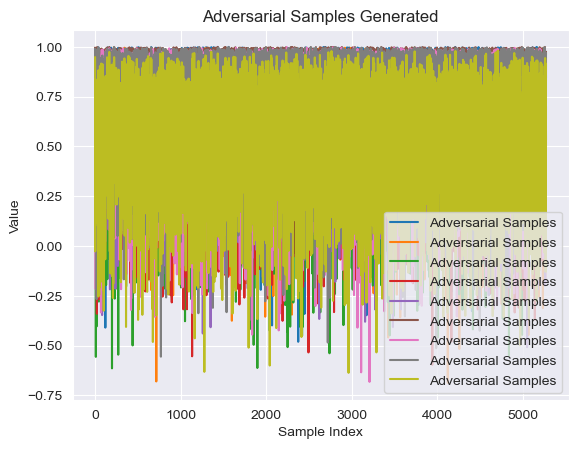

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
Predictions on adversarial examples (discriminator output): [0.99997234]
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.9949 - loss: 0.0472
Test Loss: 0.040053725242614746
Test Accuracy: 0.9963980913162231
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
Original accuracy: 0.6176
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.9949 - loss: 0.0473
Test Loss: 0.040053725242614746
Test Accuracy: 0.9963980913162231
Adversarial accuracy: 1.0000


,id.orig_port,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes
46730,5151,53,2,5.030600,4,1,540,0,0
48393,61215,53,2,5.030600,4,1,540,0,0
41416,60587,53,2,5.030600,4,1,540,0,0
34506,52092,23,1,3.119981,4,3,180,0,0
43725,5566,53,2,5.030600,4,1,540,0,0
...,...,...,...,...,...,...,...,...,...
6370,53443,42564,1,59.000000,6,71,1093,3,914
6371,37658,51045,1,64.000000,5,70,2775,4,1586
6372,42609,50062,1,66.000000,6,51,2590,3,1368
6373,63301,35273,1,93.000000,5,60,1888,3,1527


In [902]:
import matplotlib.pyplot as plt

# Assuming adversarial_samples is a 1D array or list
plt.plot(adversarial_samples, label='Adversarial Samples')
plt.title('Adversarial Samples Generated')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()


# Evaluate classifier's performance on adversarial samples
predictions_on_adversarial = discriminator.predict(adversarial_samples)
print("Predictions on adversarial examples (discriminator output):", predictions_on_adversarial[0])

# To check detection evasion success:
# If the discriminator is predicting "real" (output near 1) for adversarial examples,
# then the detection evasion is successful.

# You can also compare the classifier's performance on original vs adversarial samples:
# Original test accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

original_predictions = discriminator.predict(X_test)
original_accuracy = (original_predictions >= 0.5).mean()
print(f"Original accuracy: {original_accuracy:.4f}")

test_loss, test_accuracy = discriminator.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Adversarial test accuracy
adversarial_accuracy = (predictions_on_adversarial >= 0.5).mean()
print(f"Adversarial accuracy: {adversarial_accuracy:.4f}")
X

In [903]:
import pandas as pd

# Load the CSV file
csv_file = "flows.csv"
data = pd.read_csv(csv_file)  # Skip the first row if it contains metadata
data

selected_features = ['sa', 'sp', 'td', 'ipkt', 'ibyt']
X = data[selected_features]
X['sa'] = X['sa'].map(lambda ip: int(ipaddress.IPv4Address(ip)))

model.predict(X)

/var/folders/nj/scyrvwln431b58h3d50x1v600000gn/T/ipykernel_54983/354701489.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sa'] = X['sa'].map(lambda ip: int(ipaddress.IPv4Address(ip)))


InvalidArgumentError: Graph execution error:

Detected at node sequential_103_1/dense_310_1/MatMul defined at (most recent call last):
  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/nj/scyrvwln431b58h3d50x1v600000gn/T/ipykernel_54983/354701489.py", line 12, in <module>

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 510, in predict

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 198, in one_step_on_data

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 96, in predict_step

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/models/sequential.py", line 213, in call

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/models/functional.py", line 182, in call

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/models/functional.py", line 584, in call

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/layers/core/dense.py", line 144, in call

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/ops/numpy.py", line 3733, in matmul

  File "/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/backend/tensorflow/numpy.py", line 477, in matmul

Matrix size-incompatible: In[0]: [32,5], In[1]: [9,64]
	 [[{{node sequential_103_1/dense_310_1/MatMul}}]] [Op:__inference_one_step_on_data_distributed_6245202]